# Tutorial notebook for classification on extreme covariates

Implements and illustrates the methodology and theory developed in

    *  Jalalzai, H., Clémençon, S., & Sabourin, A. (2018). On binary classification in extreme regions. Advances in Neural Information Processing Systems, 31.

    * Clémençon, S., Jalalzai, H., Lhaut, S., Sabourin, A., & Segers, J. (2023). Concentration bounds for the empirical angular measure with statistical learning applications. Bernoulli, 29(4), 2797-2827.

    * Aghbalou, A., Bertail, P., Portier, F., & Sabourin, A. (2024). Cross-validation on extreme regions. Extremes, 27(4), 505-555.

## Table of Contents
* [Preliminary manipulations](#Preliminary)
* [Data generation](#Data_generation)
* [Choice of k, Episode 1.](#Choice_k_1)
* [Learning, prediction, evaluation](#Learning)
* [Choice of k: Episode 2, cross-validation](#Choice_k_2)
* [Comparison with baseline](#Baseline)
* [Nonstandard covariates: rank-transformation ](#nonstandard)

## Preliminary manipulations <a class="anchor" id="Preliminary"></a>

In [1]:
# Set working directory if necessary
import os
os.getcwd()
os.chdir("../")

Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.linear_model import Perceptron, LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
import MLExtreme as mlx

Choose a norm function according to which 'extreme' covariates will be
selected

In [3]:
def norm_func(x):
    return np.linalg.norm(x, ord=2, axis=1)

## Data generation <a id="Data_generation"></a>

 ** Generative Model Overview **

In this toy example, each class (conditioned on $ y = 1 $ or $  y = 0 $) follows a heavy-tailed, regularly varying bivariate distribution. The tail angular measure differs from the bulk angular distribution, requiring a bias-variance trade-off when setting the training radial threshold. This threshold determines which samples are considered 'extreme', crucial for optimizing model performance in the covariates' tail.

**N.B**:  The assumptions of Jalalzai et al. (2018) are satisfied in the first part of the tutorial. In a second step we consider a setting where a  marginal transformation of the covariates is necessary, and we use the rank-transformatoin considered in Clémençon et al (2023). 

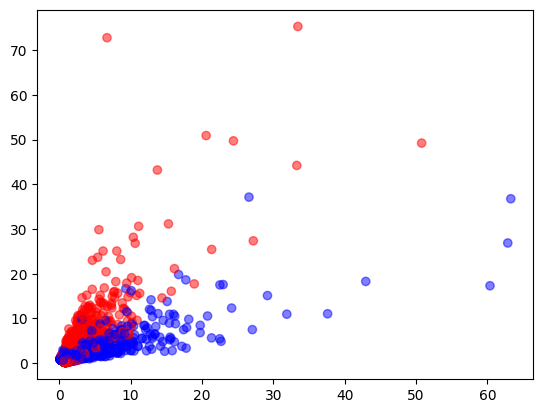

In [4]:
# data generation
n = 40000
np.random.seed(1)
X, y = mlx.gen_classif_data_diriClasses(mu0=np.array([0.7, 0.3]),
                                        lnu=np.log(10)*np.ones(2),
                                        alpha=2,
                                        index_weight_noise=0.51, size=n)
# more details: 
# help(mlx.gen_classif_data_diriClasses)


# Visualization of the generated data
colors = np.where(y == 1, 'red', 'blue').flatten()
plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.5)
plt.show()
#

In [5]:
# Splitting the data into training and test sets
split = 3/4  # test_size: simulated data : may be set arbitrarily large upon increasing n
n_train = n * (1-split)
# n_test = n * split 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=split,
                                                    random_state=42)

## Choice of k, Episode 1. <a class="anchor" id="Choice_k_1"></a>

(For adaptive choice of k_train by cross-validation, see Episode 2 below)

To choose `k_train' the number of extreme training samples at the training step,
we suggest the following rule of thumb:

Select k_train as the largest k such that a distance covariance test [1] cannot reject the null hypothesis that the radius is independent from the pair (Angle, covariate). For small values of k, the p-value is computed by a permutation test, as justified in spirit in [2].  To avoid instabilities due to lack of moments of the radial variable, a log-transformation is applied.

Computation of the test statistics and p-values relies on the `dcor' package
https://dcor.readthedocs.io/en/stable/installation.html

Assuming `k_train` is correctly chosen,  theoretical guarantees at the
prediction test  cover in principle any `thresh_predict` such that:

` thresh_predict > np.quantiles(norm_func(X_test), 1 -  k_train/n_train) `

References
---------

[1] Székely, G. J., Rizzo, M. L., & Bakirov, N. K. (2007). Measuring and testing dependence by correlation of distances.

[2] Wan, P., & Davis, R. A. (2019). Threshold selection for multivariate heavy-tailed data. Extremes, 22(1), 131-166.

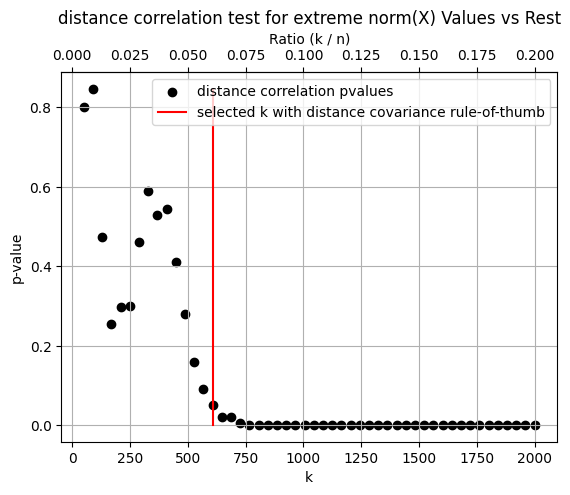

607 0.061


In [6]:
ratios = np.linspace(50/n_train, 0.2, num=50)
pvalues, ratio_max = mlx.test_indep_radius_rest(X_train, y_train, ratios,
                                                norm_func)
# plot 
mlx.plot_indep_radius_rest(pvalues, ratios, ratio_max, n_train)
# k ~ 700 maximum on this example.

k_max = int(ratio_max * n_train)
print(k_max, mlx.round_signif(ratio_max, 2))

In [7]:
# Set training and prediction ratios accordingly:
ratio_train = ratio_max * 4/5
ratio_test = ratio_max / 2  # higher quantile than training quantile: 
norm_X_train = norm_func(X_train)
thresh_predict = np.quantile(norm_X_train, 1-ratio_test)
thresh_train = np.quantile(norm_X_train, 1-ratio_test)
k_train = int(ratio_train * n_train)
print(k_train, thresh_train)

485 4.183209785761688


## Learning, prediction, evaluation <a class="anchor" id="Learning"></a>

Choice of an off-the-shelf classification algorithm
see https://scikit-learn.org/stable/supervised_learning.html

0-1 loss: 0.2098


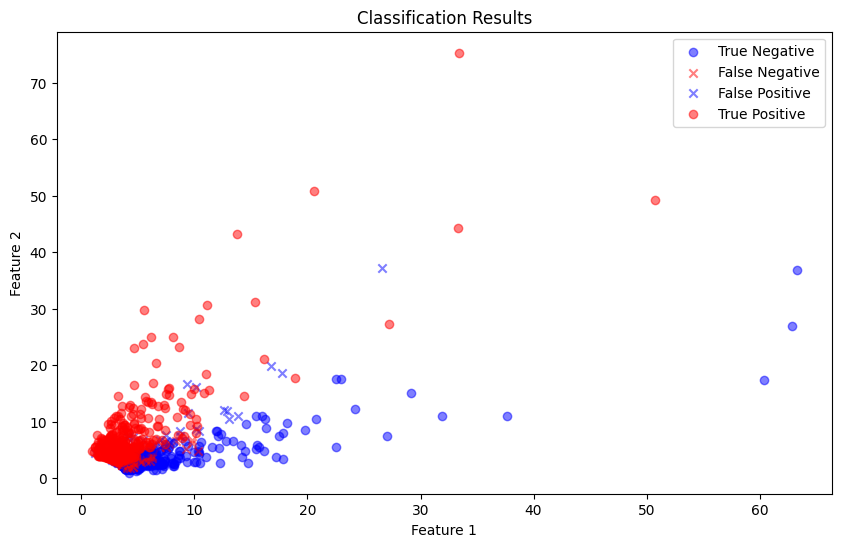

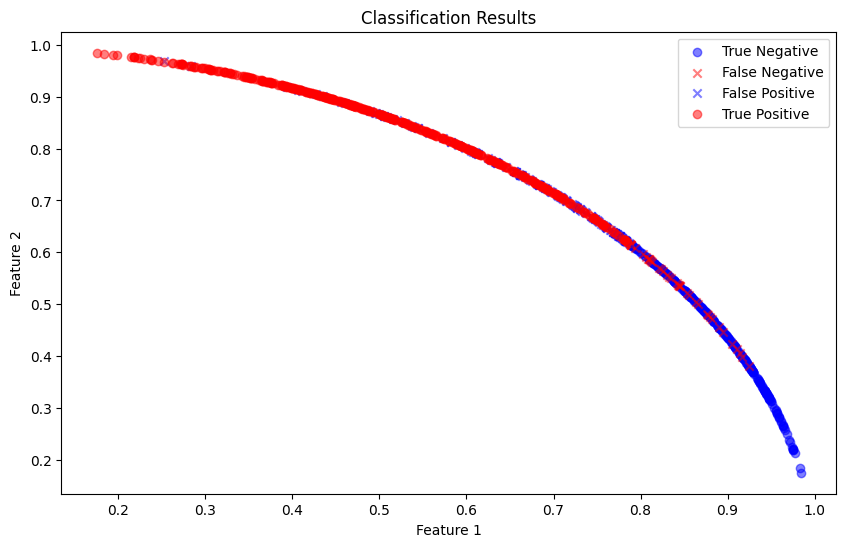

In [8]:
# Pick a classification model in sklearn, previously imported
model = Perceptron()   # RandomForestClassifier()
# Classifier class initialization
classifier = mlx.Classifier(model, norm_func)

# Model training
threshold, ratio, X_train_extreme = classifier.fit(X_train, y_train, k_train)

# Prediction on the test data above a larger threshold (extrapolation)
y_pred_extreme,  X_test_extreme, mask_test = classifier.predict(
                                            X_test, thresh_predict)
# Performance  evaluation: Hamming loss (=0-1 loss)
y_test_extreme = y_test[mask_test]
hamming = hamming_loss(y_test_extreme, y_pred_extreme)
print(f'0-1 loss: {hamming:.4f}')

# Display classification results:
# on the original scale 
classifier.plot_classif(X_test_extreme, y_test_extreme, y_pred_extreme)

# normalizing the covariate: 
X_test_extrem_unit = X_test_extreme / norm_func(X_test_extreme)[:, np.newaxis]
classifier.plot_classif(X_test_extrem_unit, y_test_extreme, y_pred_extreme)

### Preliminary sanity check: comparison with baseline. 

In [9]:
# fitting the regression model on the full dataset
naive = model
naive.fit(X_train, y_train)
# performance on extreme test set: 
y_pred_naive_extreme = naive.predict(X_test_extreme)
hamming_naive_extreme = hamming_loss(y_test_extreme, y_pred_naive_extreme)
print(f'0-1 loss of naive model on extreme test set : {hamming_naive_extreme:.4f}')
print(f'0-1 loss of MLX model on extreme test set: {hamming:.4f}')

0-1 loss of naive model on extreme test set : 0.5123
0-1 loss of MLX model on extreme test set: 0.2098


## Cross-validation for model choice and choice of k <a class="anchor" id="Crossval"></a>

Two purposes are envisioned for cross-validation here:

    (a) Evaluating model performance on extremes and choosing a good classification model

    (b) choice of `k_train`, Episode 2

 ### 3.a goal: choosing a classification model

In [10]:
# choice of  2 classification algorithm
model1 = Perceptron() ##RandomForestClassifier()
model2 = LogisticRegression()  ##GradientBoostingClassifier()

# Classifier class initialization
classifier1 = mlx.Classifier(model1, norm_func)
classifier2 = mlx.Classifier(model2, norm_func)

hamming_loss1 (std): 0.2928512141319518  (0.04223107730765287)
hamming_loss2 (std): 0.18003027346060133  (0.033609162863724715)


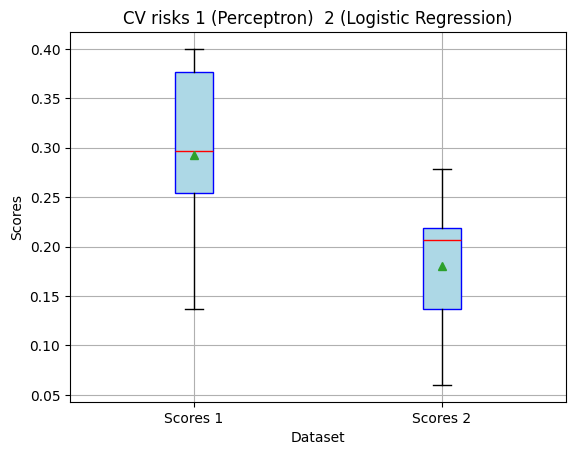

In [11]:
#  Perform cross-validation (may be time consuming) for fixed thresh_train
#  to compare the two models 
mean_scores1, sd_mean_scores1, scores1 = classifier1.cross_validate(
    X_train, y_train, thresh_train=thresh_train, thresh_predict=thresh_predict,
    random_state=42)

mean_scores2, sd_mean_scores2, scores2 = classifier2.cross_validate(
    X_train, y_train, thresh_train=thresh_train, thresh_predict=thresh_predict,
    random_state=42)

print(f"hamming_loss1 (std): {mean_scores1}  ({sd_mean_scores1})")
print(f"hamming_loss2 (std): {mean_scores2}  ({sd_mean_scores2})")

plt.boxplot([scores1, scores2], tick_labels=['Scores 1', 'Scores 2'],
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'), showmeans=True)
plt.xlabel('Dataset')
plt.ylabel('Scores')
plt.title('CV risks 1 (Perceptron)  2 (Logistic Regression)')
plt.grid()
plt.show()
# Logistic regression  seems to perform  better on this toy example.

### 3.b goal:  choosing the training threshold.
        (designed for a fixed prediction threshold)
in view of 3.a, we choose model2 (logistic regression).

In [12]:
classifier = mlx.Classifier(model2, norm_func)

# choose a range of training k's  (thresh_predict is defined above)
ratio_train_vect = np.linspace(0.005, 0.7, num=15)
k_train_vect = (n_train * ratio_train_vect).astype(int)
thresh_train_vect = np.array([np.quantile(norm_X_train, 1 - r)
                              for r in ratio_train_vect])

/bin/bash: line 1: consuming: command not found

real	0m0.001s
user	0m0.000s
sys	0m0.000s


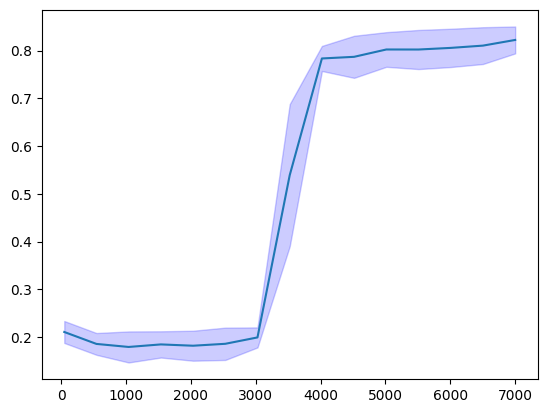

In [13]:
# compute cv scores for each value of thresh__train
# NB: setting k in the function leads to misinterpretattion REMOVE!!
kscores = []
kscores_sd = []
!time consuming
count=1
for thresh in thresh_train_vect:
    count+=1
    mean_scores, sd_mean_scores, _ = classifier.cross_validate(
        X_train, y_train, thresh_train=thresh, thresh_predict=thresh_predict,
        scoring=hamming_loss,
        random_state=42 + 103*count)
    kscores.append(mean_scores)
    kscores_sd.append(sd_mean_scores)

kscores = np.array(kscores)
kscores_sd = np.array(kscores_sd)
plt.plot(k_train_vect, kscores)
plt.fill_between(k_train_vect, kscores + 1.64 * kscores_sd,
                 kscores - 1.64 * kscores_sd, color='blue', alpha=0.2)
plt.show()

In [14]:
i_opt = np.argmin(kscores)
k_opt = k_train_vect[i_opt]
print(f'Optimal k selected by CV: {k_opt}')
ratio_opt = thresh_train_vect[i_opt]
print(f' optimal training ratio selected by CV: {ratio_opt}')
# choice of k around k=1500  looks optimal with model 2
# for predicting above thresh_predict fixed above.

Optimal k selected by CV: 1042
 optimal training ratio selected by CV: 2.2173250285206594


In [15]:
# Is model 2 still the best with k_train = k_opt ?
mean_scores1, sd_mean_scores1, scores1 = classifier1.cross_validate(
    X_train, y_train, k=k_opt, thresh_predict=thresh_predict, random_state=42)

mean_scores2, sd_mean_scores2, scores2 = classifier2.cross_validate(
    X_train, y_train, k=k_opt, thresh_predict=thresh_predict, random_state=42)

print(f"hamming_loss1 (std): {mean_scores1}  ({sd_mean_scores1})")
print(f"hamming_loss2 (std): {mean_scores2}  ({sd_mean_scores2})")
# yes

hamming_loss1 (std): 0.3015630366900859  (0.08006567856989862)
hamming_loss2 (std): 0.18330896198519148  (0.03560285855780753)


In [16]:
# Retrain Model 2,  with k_train = k_opt and evaluate on test set
classifier_cv = mlx.Classifier(model2, norm_func)
classifier_cv.fit(X_train,  y_train, k=k_opt)
# Prediction on the test data
y_pred_extreme_cv, _ , _ = classifier_cv.predict(
                                            X_test, thresh_predict)

# For comparison: train classifier2 with rule-of-thumb k_train  and evaluate on test set
classifier2 = mlx.Classifier(model2, norm_func)
classifier2.fit(X_train,  y_train, k= k_train)
# Prediction on the test data
y_pred_extreme2,  _, _= classifier2.predict(X_test, thresh_predict)

# For comparison: naive method (model2) on full dataset and predict on extremes
naive = model2
naive.fit(X_train, y_train)
y_pred_naive = naive.predict(X_test_extreme)

# 0-1 loss  evaluation on extremes
y_test_extreme = y_test[mask_test]
hamming_cv = hamming_loss(y_test_extreme, y_pred_extreme_cv)
hamming_model2_thumb = hamming_loss(y_test_extreme, y_pred_extreme2)
hamming_naive =  hamming_loss(y_test_extreme, y_pred_naive)

#
# Results with 0.95 confidence intervals: 

def half_ci(x):
   return  1.64*np.sqrt( x * (1-x)/ len(y_test_extreme))

print(f'hamming  naive: {hamming_naive:.4f}, \
({hamming_naive - half_ci(hamming_naive):.4f}, \
{hamming_naive + half_ci(hamming_naive):.4f})')
print(f'hamming  model1 before cv: {hamming:.4f}, \
({hamming - half_ci(hamming):.4f}, {hamming + half_ci(hamming):.4f})')
print(f'hamming  model2 before  cv: {hamming_model2_thumb:.4f}, \
({hamming_model2_thumb - half_ci(hamming_model2_thumb):.4f},  \
{hamming_model2_thumb + half_ci(hamming_model2_thumb):.4f})')
print(f'hamming  model2 after cv: {hamming_cv:.4f}, \
({hamming_cv - half_ci(hamming_cv):.4f},  \
{hamming_cv + half_ci(hamming_cv):.4f})')

hamming  naive: 0.7757, (0.7528, 0.7985)
hamming  model1 before cv: 0.2098, (0.1875, 0.2321)
hamming  model2 before  cv: 0.1875, (0.1661,  0.2089)
hamming  model2 after cv: 0.1797, (0.1587,  0.2007)


Naive method fails.
CV and rule of thumb have similar performance. Model 2 (logistic) outperforms Model 1 (perceptron)



##  Non-standard input. <a class="anchor" id="nonstandard"></a>

(coordinates of X may have different regular variation indices,
or even not be regularly varying at all).

For pedagogical purpose here we transform one column of X. However the rank
transformation used below is insensitive to monotonic transformation so the
results would be unchanged without this preliminary transformation .
transform one component of X: X_raw is not jointly regularly varying.

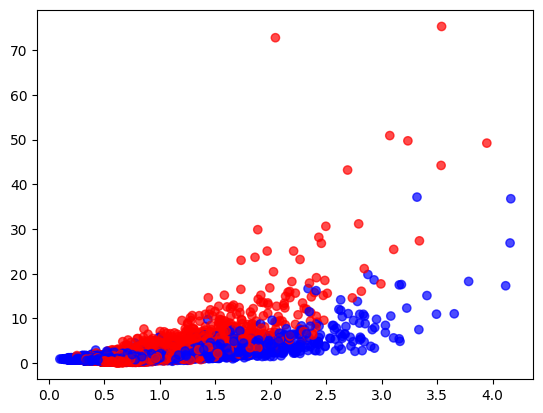

In [17]:
# Arbitrary  (nonlinear) transformation of one component of the input
# the result in now considered as 'raw data'
X_raw = np.copy(X)
X_raw[:, 0] = np.log(1 + X[:, 0])
colors = np.where(y == 1, 'red', 'blue')
plt.figure()
plt.scatter(X_raw[:, 0], X_raw[:, 1], c=colors, alpha=0.7)
plt.show()

In [18]:
# Splitting the raw data into training and test sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw,  y,
                                                            test_size=split,
                                                            random_state=42)

In [19]:
# rank-transform the training input into unit Pareto margins
X_train_rt = mlx.rank_transform(X_train_raw)
# learn the rank transformation on X_train and apply it to X_test
X_test_rt = mlx.rank_transform_test(x_train=X_train_raw, x_test=X_test_raw)

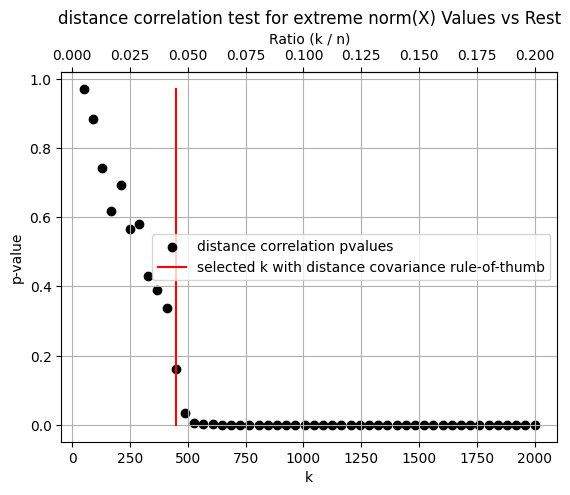

In [20]:
# Rule-of-thumb choice of k
ratios = np.linspace(50/n_train, 0.2, num=50) 
pvalues_rt, ratio_max_rt = mlx.test_indep_radius_rest(X_train_rt, y_train,
                                                      ratios,
                                                      norm_func) 
mlx.plot_indep_radius_rest(pvalues_rt, ratios, ratio_max_rt, n_train)
# k ~ 400 maximum on this example.

In [21]:
k_max_rt = int(ratio_max_rt * n_train)
# new rule-of-thumb k_max_rt: 
print(k_max_rt, mlx.round_signif(ratio_max_rt, 2))
# previously (with standdard data): 
print(k_max, mlx.round_signif(ratio_max, 2))

447 0.045
607 0.061


In [22]:
# Set training and predictio ratios accordingly:
ratio_train = ratio_max_rt * 4/5
ratio_test = ratio_max_rt / 2  # higher quantile than training quantile: 
norm_X_train = norm_func(X_train_rt)
thresh_predict = np.quantile(norm_X_train, 1-ratio_test)
thresh_train = np.quantile(norm_X_train, 1-ratio_test)
k_train = int(ratio_train * n_train)
print(k_train, thresh_train)

358 74.27834189113564


In [23]:
# ### Learning on transformed inputs

In [24]:
# choice of a classification algorithm
model = model2
# Classifier class initialization
classifier = mlx.Classifier(model, norm_func)

# Model training on standardized data
threshold, ratio, _ = classifier.fit(X_train_rt, y_train, k=500)

# Prediction on the standardized test data
y_pred_extreme_rt, _ , mask_test_rt = classifier.predict(
                                            X_test_rt, thresh_predict)

# Accuracy evaluation
y_test_extreme_rt = y_test[mask_test_rt]
hamming_rt = hamming_loss(y_test_extreme_rt, y_pred_extreme_rt)
print(f'0-1 loss (with rank transformation): {hamming_rt:.4f}')

# recall 
print(f'0-1 loss (without rank transformation): {hamming_model2_thumb:.4f}')

0-1 loss (with rank transformation): 0.1550
0-1 loss (without rank transformation): 0.1875


Performance similar to case 1. Rank-transformation does not significantly
alter the results.


**N.B. ** The extreme train/test sets obtained with standardized data are a priori different from the standard case.   However the proportion of disagreements is moderate:

In [25]:
print(f' proportion of discordant selections of extremes on the test set: \n \
 {hamming_loss(mask_test,mask_test_rt):4f}')

 proportion of discordant selections of extremes on the test set: 
  0.008367
